# <center> Yelp! Customer Reviews Analytics</center>
<center> BIA 660B- Professor. Rong Liu </center>
<center> Presented by: </center>
<center> Jui Pendharkar, Krishma Shah, Sukit Kajonpradapkul, Vaibhav Shanbhag</center>


# Introduction:
Online reviews and customer feedback can give businesses great insight in order to improve their business model. Even though review-like data is readily availabe and easily accessible on social media platforms, there is no easy solution to analysing the unstructred text data. 

Through our project, we propose to analyse the reviews for Coffee shopes and Cafes in Manhattan, NY and develop a method to extract business intellect from reviews. We want to understand what are the factors that cause a customer to be satisfied or disatisfied.This insight can help the coffee shops to improve customer satisfaction, thus improving their revenues. 

# Scrape reviews from Yelp! website:
The data used in this project was scraped from the Yelp! website. Our dataset consists of 10,269 reviews across various Coffee shops and Cafes in the whole of Manhattan area. We have considered cafes that had a minimum of 100 reviews in our analysis. 

Attributes like name of the cafe, overall rating of the cafe, review text, rating and review date of individual review text and location of the cafe were scrapped from the website. Selenium was used to scrape data and the scraped data was stored in a .csv format.

In [35]:
# Code for scraping data and export as a csv file.

from selenium import webdriver
import time
import json
import pandas as pd


# Get all cafe links for a defined number of pages.
def getCafelink(num_of_page):
        
    executable_path = 'geckodriver'
    driver = webdriver.Firefox(executable_path=executable_path)
    driver.implicitly_wait(10)
    driver.get('https://www.yelp.com/search?find_desc=\
    Caf%C3%A9s%20%26%20Coffee%20Shops&find_loc=Manhattan%2C%20New%20York%2C%20NY')
    time.sleep(5)
    # define a variable of list to store all cafe links.
    list_cafe_link = []
    
    # loop for each page
    for page in range(num_of_page):             
        cafe_name_list = []   
        above_100_review_cafe = []  
        cafe_name = driver.find_elements_by_xpath("//a[@class = 'lemon--a__373c0__IEZFH link__373c0__29943 link-color--blue-dark__373c0__1mhJo link-size--inherit__373c0__2JXk5']")
        cafe_num_review = driver.find_elements_by_xpath("//span[@class = 'lemon--span__373c0__3997G text__373c0__2pB8f reviewCount__373c0__2r4xT text-color--mid__373c0__3G312 text-align--left__373c0__2pnx_']")
   
        #Get cafe names on one page
        for selenium in cafe_name[6:65]:
            if not selenium.text =="read more":
                cafe_name_list.append(selenium.text)
                
        # focus on cafe with less than 100 reviews and below 200.
        for index in range(len(cafe_num_review[3:33])):
            if int(cafe_num_review[3:33][index].text.split()[0]) >= 100\
            and int(cafe_num_review[3:33][index].text.split()[0]) < 200:
                above_100_review_cafe.append(cafe_name_list[index])
                
        # Get Cafe links from each name    
        try:          
            for cafe in above_100_review_cafe:
                cafe_link = driver.find_element_by_link_text(cafe)
                list_cafe_link.append(cafe_link.get_attribute('href'))
        except:
            print ("Check your internet speed, Errors occur on {} page, Check your internet speed.".format(page)) 
            
        # Get a link to next page and click the link, then delay for 5 seconds for page loading.      
        try:                         
            next_page = driver.find_elements_by_xpath("//a[@class = 'lemon--a__373c0__IEZFH link__373c0__29943 next-link navigation-button__373c0__1D3Ug link-color--blue-dark__373c0__1mhJo link-size--default__373c0__1skgq']")[-1]
            next_page.click()        
            time.sleep(5)
        except:
            print (" Check your internet speed, Cannot Click to Next page, Stop scaping restaurant link")

        
    driver.quit()
     # Return a list of cafe links                   
    return list_cafe_link

        
# Function to scrape review data
def getData(list_of_links):

    list_of_data = []

    
    print (list_of_links)    
    for link in list_of_links:
        print (link)
        executable_path = 'geckodriver'
        driver = webdriver.Firefox(executable_path=executable_path)
        driver.implicitly_wait(10)
        driver.get(link)
        time.sleep(5)
        try:
        # Get Cafe name
            cafe_name = driver.find_elements_by_xpath("//meta[@itemprop = 'name']")[1].get_attribute('content')
            
            # Get rating from average and individual
            rating_list = driver.find_elements_by_xpath("//meta[@itemprop = 'ratingValue']")    
            # Get average_rating
            average_rating = rating_list[0].get_attribute('content')
            
            
            
            # Get JSON file from Xpath, and use json.loads to get latitude and longtitude as a dict
            get_lat_and_long = driver.find_elements_by_xpath("//div[@class= 'lightbox-map hidden']")
            latitude_longitude = json.loads(get_lat_and_long[0].get_attribute('data-map-state'))['center']
            latitude = latitude_longitude['latitude']
            longtitude = latitude_longitude['longitude']
        except:
            print ("Check your internet speed, Error occurs on the link {}, Skip this restaurant".format(link))
        
        # Loop each review page.   
        while True:
            try:
                
                # Get a review list.
                review_list = driver.find_elements_by_xpath("//p[@lang = 'en']")
                # Get an individual rating list
                individual_rating = rating_list[1:]
                # Get a review date list.
                review_date = driver.find_elements_by_xpath("//span[@class= 'rating-qualifier']")
                # Get a useful number list.
                useful_list = driver.find_elements_by_xpath("//a[@class= 'ybtn ybtn--small ybtn--secondary useful js-analytics-click']/span[@class='count']")
                # Get a funny number list.
                funny_list = driver.find_elements_by_xpath("//a[@class= 'ybtn ybtn--small ybtn--secondary funny js-analytics-click']/span[@class='count']")
                # Get a cool number list.
                cool_list = driver.find_elements_by_xpath("//a[@class= 'ybtn ybtn--small ybtn--secondary cool js-analytics-click']/span[@class='count']")

            
                # Get each review, rating, useful, funny, cool, and review date,  then put everything in a tuple
                # and append the tuple to the list.
                for index in range(len(review_list)):
                                
                    review = review_list[index].text.replace('\n', ' ')
                    rating = individual_rating[index].get_attribute('content')
                    date = review_date[index].text.split()[0]
                    
                    if useful_list[index].text.isdigit():
                        useful = useful_list[index].text
                    else:
                        useful = 0
                        
                    if funny_list[index].text.isdigit():
                        funny = funny_list[index].text
                    else:
                        funny = 0
                        
                    if cool_list[index].text.isdigit():
                        cool = cool_list[index].text
                    else:
                        cool = 0
                    
                    list_of_data.append((cafe_name, average_rating, review, rating, date, useful, funny, \
                                         cool, latitude, longtitude))                
            except:                
                print ("Check your internet speed, Error on this review page occurs, Skip the page")
                
            # Click to next review page and wait for 5 seconds for page to load. if there's no next page, error gets made,                 
            # and break the while loop.
            try:
                next_page = driver.find_element_by_xpath("//a[@class = 'u-decoration-none next pagination-links_anchor']")       
                next_page.click()        
                time.sleep(5)
            except:
                break
        # Close Firefox browser
        driver.quit()
    
    # Create colum name for dataframe.
    columns = ['cafe_name', 'avg_rating', 'review', 'indv_rating', 'review_date', 'useful', \
               'funny', 'cool', 'latitude', 'longtitude']
    # Create a data frame for all data.
    df = pd.DataFrame(list_of_data, columns = columns)
    
    df.to_csv("Review data.csv", index=False)


# Call functions to get all reviews for 2 pages.
getData(getCafelink(2))

['https://www.yelp.com/biz/bird-and-branch-new-york?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/ground-central-new-york-4?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/culture-36-new-york-2?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/tianti-books-new-york?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/remi-flower-and-coffee-new-york-2?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/ut47-new-york-3?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/st-kilda-coffee-new-york?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/fika-new-york-18?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/maman-nomad-new-york?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/for-five-coffee-roasters-new-york-2?osq=Caf%C3%A9s+%26+Coffee+Shops', 'https://www.yelp.com/biz/box-kite-coffee-new-york-4?osq=Caf%C3%A9s+%26+Coffee+Shops']
https://www.yelp.com/biz/bird-and-branch-new-york?osq=Caf%C3%A9s+%26

# Exploratory Data Analysis:
- **Data Distribution:** 
Below code calculates the distribution of star ratings in the dataset. The emphasis of the study is more on polarising ratings (highly positive and highly negative) and less on neutral ratings (eg. 3 star ratings). Thus the reviews have been classified into two categories: Positive (Ratings 4 and 5) and Negative (Ratings 1 and 2). 

A subset of 2000 reviews (positive and negative) were selected from the total scraped reviews. The code also calculates the distribution of Positive and Negative rated reviews from the selected subset.


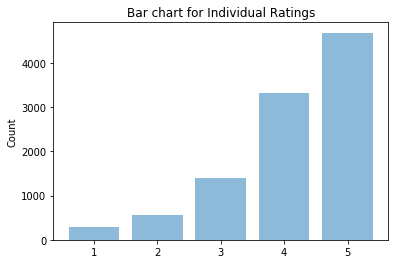

None
[Text(0, 0.5, 'cafes'), Text(0.5, 0, 'Ratings')]


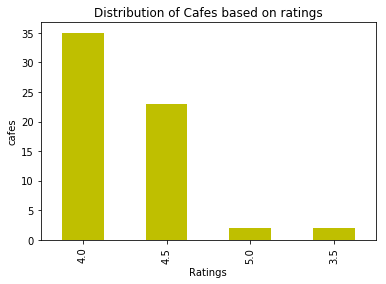

In [33]:
#Code for EDA

from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

file = r'Review_data_entire.csv'
df = pd.read_csv(file)

 
def indiv_rate():
    objects = by_key.keys()  
    y_pos = np.arange(len(objects))
    performance = by_key.values()
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title('Bar chart for Individual Ratings')
    return plt.show()

def overall_ratings():   
    df1= df[['cafe_name','avg_rating']].sort_values(['avg_rating'], ascending=[True]).drop_duplicates()

    ax=df1.avg_rating.value_counts().\
    plot.bar(figsize=(6,4), title="Distribution of Cafes based on ratings", color = 'y'); #barh = vertical bar chart

    # set labels
    return ax.set(ylabel="cafes", xlabel="Ratings");


print (indiv_rate())
print(overall_ratings())

(4370, 6)


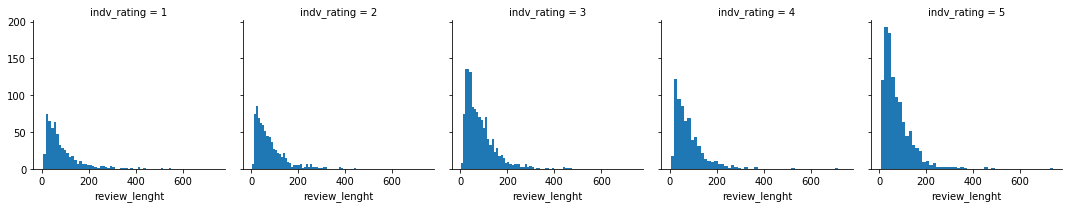

<Figure size 432x288 with 0 Axes>

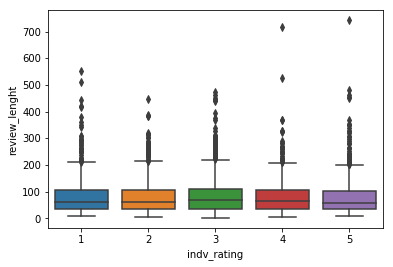

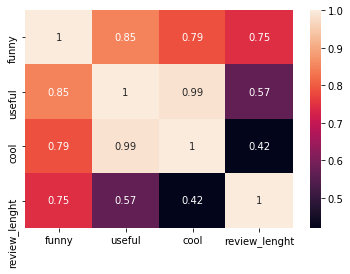

In [35]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import numpy as np

# Create function to count the lenght of words.
def count_lenght(text):
    return len(text.split())

def EDA(file):
    yelp_df = pd.read_csv(file, encoding = "latin1")
    yelp_df['review_lenght'] = yelp_df['review'].apply(count_lenght)

    yelp_data = yelp_df[['review', 'indv_rating','funny', 'useful', 'cool', 'review_lenght']]
    print(yelp_data.shape)
    star_hist = sns.FacetGrid(data = yelp_df, col = 'indv_rating')

    # histogram for the ratings
    plt.figure()
    star_hist.map(plt.hist, 'review_lenght', bins = 50)

    #box plot for individual ratings against the review-lenght 
    plt.figure()
    sns.boxplot(x = 'indv_rating', y = 'review_lenght', data = yelp_df)

    #grouping the data by individual ratings and use 
    #it generate heat maps to find the co-relation between 
    #the ratings and the cool, useful and funny 
    stars = yelp_data.groupby('indv_rating').mean()

    #.corr method to calculate the co-relation
    stars.corr()

    # heat map for to find out the corelation between the cool, useful, funny, and text length
    plt.figure()
    sns.heatmap(data=stars.corr(), annot=True)

#Call function.    
file = r'review.csv'
EDA(file)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
# for map visuallization
import folium

# define function to assign color to marker in the map.
def assign_color(rating):
    if rating == 5.0:
        return 'blue'
    elif rating == 4.5:
        return 'green'
    elif rating == 4.0:
        return 'pink'
    else:
        return 'red'
    
# import csv into Dataframe.
map_df = pd.read_csv("Review_data_entire.csv", header = 0)
# select columns and drop duplicate rows.
map_df = map_df[['cafe_name', 'avg_rating', 'latitude', 'longtitude']].drop_duplicates()
# apply function assign_color into a new columns named "color".
map_df["color"] = map_df.avg_rating.apply(assign_color)
# reset index.
map_df = map_df.reset_index(drop = True)
map_df.head(5)

,cafe_name,avg_rating,latitude,longtitude,color
0,Super Nice Coffee and Bakery,5.0,40.799032,-73.941057,blue
1,Masseria Caffé & Bakery,4.5,40.760600,-73.986041,green
2,Bluestone Lane,4.5,40.755424,-73.970568,green
3,Black Press Coffee,4.5,40.742241,-73.983118,green
4,Little Collins,4.5,40.759912,-73.969640,green


In [2]:
location_list = map_df[['latitude', 'longtitude']].values

In [3]:
# create a map with specific latitude and longitude.
_map = folium.Map(location=[40.79, -73.94], tiles='Stamen Terrain' ,zoom_start=11)

# Add markers to the map for each cafe location.
for point in range(len(location_list)):
    folium.Marker(location_list[point], popup=map_df["cafe_name"][point],\
                 icon=folium.Icon(map_df['color'][point])).add_to(_map)

# create legend using HTML.
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 20px; width: 150px; height: 120px; 
                            border:3px solid grey; z-index:9999; font-size:14px;
                            background-color: white;
                            "<br><i class="fa fa-map-marker fa-2x" style="color:lightblue"></i>&nbsp; 5-star rating &nbsp<br>
                               <i class="fa fa-map-marker fa-2x" style="color:lightgreen"></i>&nbsp; 4.5-star rating &nbsp<br>
                               <i class="fa fa-map-marker fa-2x" style="color:pink"></i>&nbsp; 4-star rating &nbsp<br>
                               <i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; 3.5-star rating &nbsp;
                               
                </div>
                ''' 
# add legend.
_map.get_root().html.add_child(folium.Element(legend_html))
_map
    

# Processing Data:
- Corpus Data
We have divided the reviews into two categories as stated above to create two sets of corpus data that will be analysed.
We have also performed an analysis of all reviews together to find the most frequent words.

- Tokenization
Next, each term was extracted from the corpus through tokenization.
Steps for tokenization using spaCy:
1. strip punctuation and  convert to lower case
2. Remove stopwords
3. POS tagging of tokens and lemmatization



- Frequency Term Matrix
After pre-processing, a frequency term matrix was created for the positive and negative reviews each. Within the frequency term matrix, rows represent each review and columns represent tokenized terms or tokens. The sum of occurrence of term j within review i was calculated and assigned to cell i,j within the matrix. 

- Reduce Frequency Term Matrix


In [197]:
# code for tokenization

import re
import nltk
import string
import en_core_web_sm 
nlp = en_core_web_sm.load()

# this function is to get either Noun or Adjective from the entered string(text).
def get_words(text, get_noun = True, get_adj = True):
    
    # Strip punctuation from string and lowercase the string
    text = " ".join([token.strip(string.punctuation) for token in text.split()]).lower()
    
    # Define a text to Spacy
    doc = nlp(text)
    
    # call stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    
    words = []
    # Loop through each word in the text.
    for token in doc:
        # Get only adjective
        if (get_adj == True) and (get_noun == False):
            if (not token.text in string.punctuation) and (not token.is_space) \
                    and (not token.text in stop_words) and ((token.pos_ == 'ADJ')):   
                        words.append(token.lemma_)
        # Get only Noun
        elif (get_adj == False) and (get_noun == True):
            if (not token.text in string.punctuation) and (not token.is_space) \
                    and (not token.text in stop_words) and ((token.pos_ == 'NOUN')):   
                        words.append(token.lemma_)
        # Get Both Noun and Adjective
        elif (get_adj == True) and (get_noun == True):
            if (not token.text in string.punctuation) and (not token.is_space) \
                    and (not token.text in stop_words) and ((token.pos_ == 'ADJ'\
                                                           or token.pos_ == 'NOUN')):   
                        words.append(token.lemma_)
        else:
            return "Nothing"
     # Return a list of words   
    return words

# This function is to get frequent words of either noun or adjective from a dataframe of reviews
# with specified individual ratings.
def get_frequent_word(df, indv_rating_1 = None,indv_rating_2 = None, get_noun = True, get_adj = True):
    # Get all reviews from a dataframe into a list
    list_of_reviews = df[(df['indv_rating'].apply(float)==indv_rating_1) | \
                      (df['indv_rating'].apply(float)==indv_rating_2)].review.values.tolist()
    
    # get words by calling get_word function.
    tokenized_rating = get_words(" ".join(list_of_reviews), get_noun, get_adj)
    # Count all frequent words
    docs_tokens = {token:tokenized_rating.count(token) for token in set(tokenized_rating)}
     # return a list of top 15 frequent words.
    return sorted(docs_tokens.items(), key=lambda x: x[1])[::-1][:15]
    
# Get Frequent words from all reviews
def get_frequent_word_all_review(df, N,get_noun = True, get_adj = True):
    # Get all reviews from a dataframe into a list
    list_of_reviews = df.review.values.tolist()
    
    # get words by calling get_word function.
    tokenized_rating = get_words(" ".join(list_of_reviews), get_noun, get_adj)
    # Count all frequent words
    docs_tokens = {token:tokenized_rating.count(token) for token in set(tokenized_rating)}
     # return a list of top 15 frequent words.
    return sorted(docs_tokens.items(), key=lambda x: x[1])[::-1][:N]

# This funciton is to get most frequent bigrams from reviews in a dataframe.
def get_bigrams(df, N, indv_rating_1 = None, indv_rating_2 = None):
    
    # a list of negative words
    negations = ['no','nor','not','too','don',"don't",'ain','aren',"aren't",'couldn',"couldn't",\
    'didn',"didn't",'doesn','isn',"isn't",'wasn',"wasn't",'weren',"weren't"]
    
    # Call stopwords and remove negative words from them
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = [word for word in stop_words if not word in negations]
    
    # Get a list of all reviews
    list_of_reviews = df[(df['indv_rating'].apply(float)==indv_rating_1) | \
                  (df['indv_rating'].apply(float)==indv_rating_2)].review.values.tolist()
    # Get a string of text
    text = " ".join(list_of_reviews).lower()
    # Create pattern
    pattern=r'\w[\w\'-]*\w'                        
    # Get tokens
    tokens = nltk.regexp_tokenize(text, pattern)
    # Remove stopwords from tokens
    filtered_tokens = [token for token in tokens if not token in stop_words]
    # Get bigrams
    bigrams=list(nltk.bigrams(filtered_tokens))
    # get freqent bigrams    
    frequent_bigram = {bigram:bigrams.count(bigram) for bigram in set(bigrams)}
    
    # return top N frequent bigrams
    return sorted(frequent_bigram.items(), key=lambda x: x[1])[::-1][:N]

# This funciton is to get most frequent trigrams from reviews in a dataframe.
def get_trigrams(df, N, indv_rating_1 = None, indv_rating_2 = None):
    
    # a list of negative words
    negations = ['no','nor','not','too','don',"don't",'ain','aren',"aren't",'couldn',"couldn't",\
    'didn',"didn't",'doesn','isn',"isn't",'wasn',"wasn't",'weren',"weren't"]
    
    # Call stopwords and remove negative words from them
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = [word for word in stop_words if not word in negations]
    
    # Get a list of all reviews
    list_of_reviews = df[(df['indv_rating'].apply(float)==indv_rating_1) | \
                  (df['indv_rating'].apply(float)==indv_rating_2)].review.values.tolist()
    # Get a string of text
    text = " ".join(list_of_reviews).lower()
    # Create pattern
    pattern=r'\w[\w\'-]*\w'                        
    # Get tokens
    tokens = nltk.regexp_tokenize(text, pattern)
    # Remove stopwords from tokens
    filtered_tokens = [token for token in tokens if not token in stop_words]
    # Get trigrams
    trigrams=list(nltk.trigrams(filtered_tokens))
    # get freqent trigrams      
    frequent_trigram = {trigram:trigrams.count(trigram) for trigram in set(trigrams)}
    # return top N frequent trigrams
    return sorted(frequent_trigram.items(), key=lambda x: x[1])[::-1][:N]
    
    

# Analysis of Bi-grams & Tri-grams
Using bag of words, we created bi-grams and tri-grams to get further insights into the most frequently used combinations in the customer reviews describing their experiences at coffee shops and explaining their reviews. Our analysis suggests that we need to remove bi-grams which do not explain the sentiment of the reviews like (coffee, shop), (coffee, shops), (times, square), etc. and tri-grams like (favorite, coffee, shop), (flower, coffee, shop), etc.

In [38]:
# Get most frequent bigrams and Trigrams
print (get_bigrams(df, N=20, indv_rating_1 = 4, indv_rating_2 = 5))
print (get_trigrams(df, N=20, indv_rating_1 = 4, indv_rating_2 = 5))

[(('coffee', 'shop'), 263), (('cold', 'brew'), 75), (('come', 'back'), 71), (('good', 'coffee'), 65), (('great', 'coffee'), 64), (('chocolate', 'chip'), 64), (('coffee', 'shops'), 63), (('great', 'place'), 56), (('matcha', 'latte'), 54), (('work', 'done'), 52), (("hell's", 'kitchen'), 48), (('times', 'square'), 45), (('get', 'work'), 44), (('best', 'coffee'), 44), (('really', 'good'), 42), (('not', 'too'), 41), (('chip', 'cookie'), 41), (('new', 'york'), 40), (('baked', 'goods'), 40), (('almond', 'milk'), 39)]
[(('get', 'work', 'done'), 42), (('chocolate', 'chip', 'cookie'), 41), (('definitely', 'come', 'back'), 23), (('little', 'coffee', 'shop'), 21), (('chocolate', 'chip', 'cookies'), 18), (('would', 'come', 'back'), 14), (('almond', 'macadamia', 'milk'), 14), (('favorite', 'coffee', 'shop'), 14), (('would', 'definitely', 'come'), 14), (('would', 'definitely', 'recommend'), 13), (('staff', 'super', 'friendly'), 13), (('come', 'back', 'try'), 12), (('cute', 'coffee', 'shop'), 12), (('

# Analysis of most frequent words
We first analysed the most frequent words from all the reviews. An output similar to the word cloud (shown below) was obtained. Words like 'coffee',' shop', 'place' etc were used extensively which did not contribute to the meaning or sentiment of the review. We thus removed the nouns to analyise the most frequent adjectives used to give us a better understanding of the meaning of the reviews.


In [39]:
# Get top N frequent words
print (get_frequent_word(df, indv_rating_1 = 1,indv_rating_2 = 2, get_noun = False, get_adj = True))
print (get_frequent_word(df, indv_rating_1 = 4 ,indv_rating_2 = 5, get_noun = False, get_adj = True))

[('good', 48), ('nice', 33), ('great', 30), ('quiet', 15), ('little', 15), ('cute', 12), ('matcha', 12), ('friendly', 11), ('small', 11), ('delicious', 10), ('sweet', 10), ('white', 10), ('cold', 9), ('beautiful', 9), ('large', 9)]
[('good', 784), ('great', 541), ('nice', 338), ('friendly', 255), ('little', 218), ('delicious', 195), ('small', 169), ('new', 164), ('cute', 163), ('amazing', 144), ('perfect', 114), ('cold', 111), ('free', 109), ('sweet', 108), ('matcha', 100)]


### Word Clouds
Word clouds were constructed from the frequency term matrix, to visualize the overall trend of the data. Words with larger font sizes were repeated more number of times than others. 

In [112]:
from wordcloud import WordCloud

# Get Wordcloud from a dataframe
def create_wordcloud(df, title= None, indv_rating_1 = None, indv_rating_2 = None):
    
    stop_words = nltk.corpus.stopwords.words('english')
    
    list_of_reviews = df[(df['indv_rating'].apply(float)==indv_rating_1) | \
                  (df['indv_rating'].apply(float)==indv_rating_2)].review.values.tolist()
    
    # Get a string of text
    string = " ".join(list_of_reviews).lower()
    # Generate WordCloud
    plt.figure('Review')
    wc = WordCloud(background_color="white", max_words=5000, stopwords=stop_words)              
    wc.generate(string)
    plt.imshow(wc)
    plt.axis('OFF')
    plt.title(title, color = 'b')
    plt.show()
    


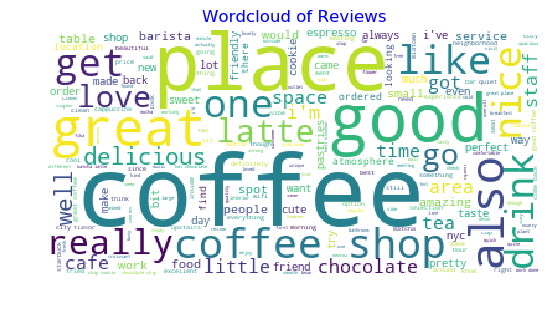

In [114]:
create_wordcloud(df, title= 'Wordcloud of Reviews', indv_rating_1 = 5, indv_rating_2 = 4)

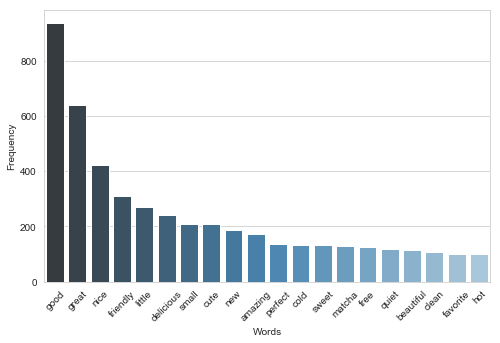

None


In [198]:
import seaborn as sns

# Call get_frequent_word_all review
Frequent_words = get_frequent_word_all_review(df,N=20, get_noun = False, get_adj = True)
# Get a dataframe of Frequent_words
frequent_word_frequent = pd.DataFrame(Frequent_words)
frequent_word_frequent.columns=["Words", "Frequency"]

# Get a bar chart for frequent words. 
def get_chart_frequent_word(frequent_word_frequent):
     
    sns.set_style("whitegrid");

    plt.figure(figsize=(8,5))
    sns.barplot(x='Words',y='Frequency', data=frequent_word_frequent, palette="Blues_d")
    plt.xticks(rotation=(45))
    plt.show()
print (get_chart_frequent_word(frequent_word_frequent))

## Order Tranding Analytics 

In [77]:
# import data.
df= pd.read_csv('Review_data_entire.csv',header=0, encoding='latin1')

# create new colums for each season if months match conditions.
df['winter'] = df['review_date'].apply(lambda x : 'winter' if re.findall(r'^\d*', x)[0] in ['12','1','2'] else np.nan)
df['summer'] = df['review_date'].apply(lambda x : 'summer' if re.findall(r'^\d*', x)[0] in ['6','7','8'] else np.nan)
df['fall'] = df['review_date'].apply(lambda x : 'fall' if re.findall(r'^\d*', x)[0] in ['9','10','11'] else np.nan)
df['spring'] = df['review_date'].apply(lambda x : 'spring' if re.findall(r'^\d*', x)[0] in ['3','4','5'] else np.nan)

In [91]:
import re
import nltk
import string


def get_bigrams_all_review(df, N):
    
    # a list of negative words
    negations = ['no','nor','not','too','don',"don't",'ain','aren',"aren't",'couldn',"couldn't",\
    'didn',"didn't",'doesn','isn',"isn't",'wasn',"wasn't",'weren',"weren't"]
    
    # Call stopwords and remove negative words from them
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = [word for word in stop_words if not word in negations]
    
    # Get a list of all reviews
    list_of_reviews = df.review.values.tolist()
    
    # Get a string of text
    text = " ".join(list_of_reviews).lower()
    
    # Create pattern
    pattern=r'\w[\w\'-]*\w'                        
    # Get tokens
    tokens = nltk.regexp_tokenize(text, pattern)
    # Remove stopwords from tokens
    filtered_tokens = [token for token in tokens if not token in stop_words]
    # Get bigrams
    bigrams=list(nltk.bigrams(filtered_tokens))
    # get freqent bigrams    
    frequent_bigram = {bigram:bigrams.count(bigram) for bigram in set(bigrams)}
    
    # return top N frequent bigrams
    return sorted(frequent_bigram.items(), key=lambda x: x[1])[::-1][:N]

In [87]:
# Get a bar chart for frequent words. 
def get_chart_frequent_word(bigrams_winter_frequent, title):
    
    sns.set_style("whitegrid");

    plt.figure(figsize=(8,5))
    sns.barplot(x='Frequency',y='Bigrams', data=bigrams_winter_frequent)
    plt.xticks(rotation=(90))
    plt.title(title)
    plt.show()


In [93]:
# Get lists of frequent bigrams.
bigrams_winter = get_bigrams_all_review(df[df['winter']=='winter'], 30)

In [94]:
bigrams_summer = get_bigrams_all_review(df[df['summer']=='summer'], 30)

In [95]:
# Create dataframes for lists of bigrams.
bigrams_winter_frequent = pd.DataFrame(bigrams_winter)
bigrams_winter_frequent.columns=["Bigrams", "Frequency"]
bigrams_summer_frequent = pd.DataFrame(bigrams_summer)
bigrams_summer_frequent.columns=["Bigrams", "Frequency"]

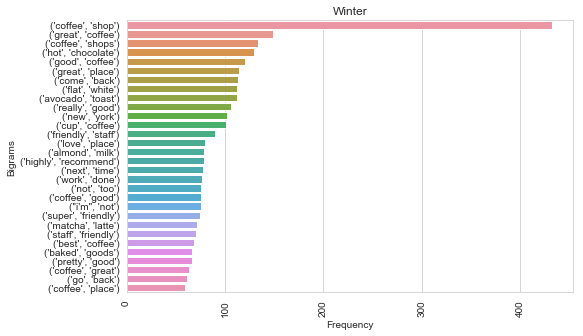

None


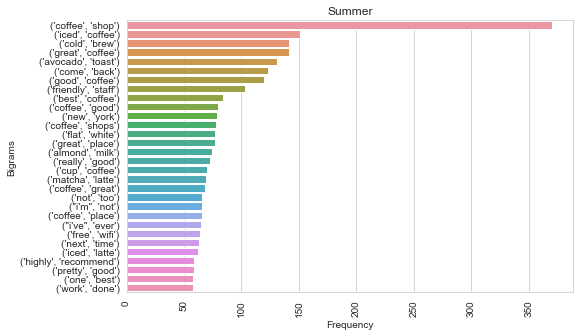

None


In [96]:
# call function to create bar graphs.
print (get_chart_frequent_word(bigrams_winter_frequent, "Winter"))
print (get_chart_frequent_word(bigrams_summer_frequent, "Summer"))

# Insights from manually reading the customer reviews:
We manually studied the customer reviews and clustered the terms from the reviews to group similar words of importance when discussing coffee shops. This will allow us to target specific aspects of running an efficient coffee shop by combining like ideas that would be separated within the frequency term matrix due to different terminology. We considered the different categories mentioned in the table below and the positive and negative terms that the customer frequently used to describe these categories.

|Category|Positive Term|Negative Term|
|:---|:---|:---|
|Taste of coffee/ food|	fantastic, amazing, bomb, best, pretty-good, good, great , perfect, delicious , quality, phenomenal, solid, loved, savoury, sweet, super cute, rich, very tasty, sweet, pure, dense, classic, perfect,delicate, excellent, die for, fluffy, beautiful|bitter, mediocre, did not like, acidic, undrinkable|
|Employee attitude|	Good conversation, amazing, good, friendly, happy, eager, nice, quick, welcoming hospitality, humour, super efficient |rude, unsociable|
|Order accuracy|super cute, nice size, perfect amount|-|
|Overall Satisfaction|great, happy, glad, went crazy, glad, hats off|disgusted, overhyped|
|Likelihood to Return|	Become regular, will be back, definitely, again, love to come back|Dont repeat|
|Cleanliness| clean, tidy|-|
|Ambience|	Super calming, Lovely, cute, spot, amazing, cute, friendly, cozy, compact, comfortable| Small, quite crowded, very narrow| 
|Service|Quick always busy, but never a long line|selective|
|Pricing|Fair, not too bad|not worth, very overpriced|

## Sentiment Analysis using classification.


In [97]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
import numpy as np

In [7]:
# import review with balanced sentiment into a dataframe.
# the review dataset is made to balance between all rating.
df= pd.read_csv('review.csv',encoding ='latin1')

# create a dataframe to store only less than 2 star rating review
# and 5 star rating reviews.
sentiment_train_data = df[(df['indv_rating'] <= 2) | (df['indv_rating'] >= 5)][['review','indv_rating']]

# create a column named sentiment to store labels 1 when ind_rating = 5 
# and labels 0 when indv_rating less than 2.
sentiment_train_data['sentiment'] = sentiment_train_data['indv_rating'].apply(lambda x: 1 if x >= 5 else 0)

# shuffle dataframe and drop individual rating columns.
sentiment_train_data = sentiment_train_data.sample(frac=1).reset_index(drop=True).drop(columns = "indv_rating")

sentiment_train_data.head()

,review,sentiment
0,"I hate to be the voice of dissent here, but I ...",0
1,My new favorite dessert spot in NYC. I cannot ...,0
2,I was in the area very early (for me anyway) a...,0
3,"Come for the coffee, stay for the ambiance. I...",0
4,Great coffee! Huge space to hang out in as wel...,0


## Multinomial Naive Bayes model Evaluation on Sentiment Analytic

In [9]:
# Define function for Naive Bayes evaluation. 
def naive_bayes_classification(review_data, sentiment_data):
    # Split dataset for training and testing.
    X_train, X_test, y_train, y_test = train_test_split(review_data, sentiment_data, test_size=0.3, random_state=0)
    
    # create pipeline for model.
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])
    # define parameters to search.
    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__max_df': [0.995 , 0.999],
                  'tfidf__stop_words':[None,"english"],
                  'clf__alpha': [0.5, 1.0, 2.0 , 5.0]}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    

    gs_clf = gs_clf.fit(X_train, y_train)
    
    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_alpha = gs_clf.best_params_["clf__alpha"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df)),
        ('clf', MultinomialNB(alpha = clf_alpha ))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(sentiment_data.unique())
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    

    print(classification_report(y_test, predicted, target_names=labels))
    
    predict_p = clf.predict_proba(X_test)
    y_pred = predict_p[:,1]
    

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    
    plt.figure();
    plt.plot(fpr, tpr, color='red');
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.savefig('AUC of Naive Bayes Model.png');

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred , pos_label=1)

    
    plt.figure();
    plt.plot(recall, precision, color='green', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.savefig('Precision_Recall_Curve of Naive Bayes Model.png');

clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.6679451659987032
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       401
           1       0.65      0.60      0.63       326

   micro avg       0.68      0.68      0.68       727
   macro avg       0.67      0.67      0.67       727
weighted avg       0.67      0.68      0.67       727



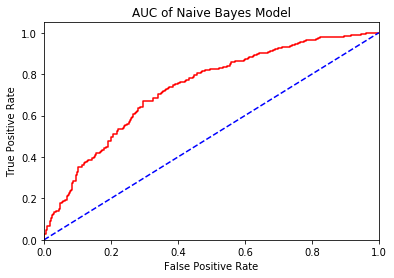

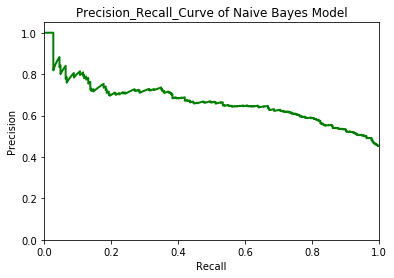

In [10]:
# Call function to run model evaluation and report performance.
naive_bayes_classification(sentiment_train_data.review, sentiment_train_data.sentiment)

## Support Vector Machine model Evaluation on Sentiment Analytic

In [12]:
def SVM_classification(review_data, sentiment_data):
    
    X_train, X_test, y_train, y_test = train_test_split(review_data, sentiment_data, test_size=0.3, random_state=0)
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__C':[ 1, 2, 5]}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    

    gs_clf = gs_clf.fit(X_train, y_train)
    
    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)


    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]
    c = gs_clf.best_params_["clf__C"]
    
    
    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df)),
        ('clf', LinearSVC(C=c))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(sentiment_data.unique())
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    

    print(classification_report(y_test, predicted, target_names=labels))

In [13]:
SVM_classification(sentiment_train_data.review, sentiment_train_data.sentiment)

clf__C : 1
tfidf__min_df : 2
tfidf__stop_words : None
best f1 score: 0.6454235481785219
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       401
           1       0.61      0.60      0.60       326

   micro avg       0.65      0.65      0.65       727
   macro avg       0.65      0.64      0.64       727
weighted avg       0.65      0.65      0.65       727



## K-nearest Neighbour model Evaluation on Sentiment Analytic

In [4]:
def KNN_classification(review_data, sentiment_data):
    
    X_train, X_test, y_train, y_test = train_test_split(review_data, sentiment_data, test_size=0.3, random_state=0)
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])
    
    k_range = list(range(1, 20))
    
    
    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__n_neighbors': k_range}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    

    gs_clf = gs_clf.fit(X_train, y_train)
    
    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)


    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]
    k = gs_clf.best_params_["clf__n_neighbors"]
    
    
    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df)),
        ('clf', KNeighborsClassifier(n_neighbors=k))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(sentiment_data.unique())
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    

    print(classification_report(y_test, predicted, target_names=labels))

In [15]:
KNN_classification(sentiment_train_data.review, sentiment_train_data.sentiment)

clf__n_neighbors : 13
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.652448991778501
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       401
           1       0.58      0.59      0.58       326

   micro avg       0.62      0.62      0.62       727
   macro avg       0.62      0.62      0.62       727
weighted avg       0.62      0.62      0.62       727



# Topic Classification without Gridsearch

## Multinomial Naive Bayes

In [116]:
def NB_topic_classification(train_file_name):
    
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)

    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(MultinomialNB(alpha = 0.5 )))])

    classifier.fit(X_train, Y_train)

    predicted = classifier.predict(X_test)

    predicted.shape
    
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  

In [117]:
NB_topic_classification("label restaurant data.csv" )

                         precision    recall  f1-score   support

               ambience       0.95      0.29      0.44       140
anecdotes/miscellaneous       0.74      0.56      0.64       342
                   food       0.83      0.72      0.77       366
                  price       0.93      0.36      0.52       102
                service       0.86      0.50      0.64       173

              micro avg       0.82      0.55      0.66      1123
              macro avg       0.86      0.49      0.60      1123
           weighted avg       0.83      0.55      0.65      1123
            samples avg       0.62      0.58      0.59      1123



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Support Vector Machine

In [101]:
def SVM_topic_classification(train_file_name):
    
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)

    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(LinearSVC(C = 1)))])

    classifier.fit(X_train, Y_train)

    predicted = classifier.predict(X_test)

    predicted.shape
    
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  

In [102]:
SVM_topic_classification("label restaurant data.csv")

                         precision    recall  f1-score   support

               ambience       0.87      0.54      0.66       140
anecdotes/miscellaneous       0.71      0.73      0.72       342
                   food       0.85      0.80      0.82       366
                  price       0.88      0.74      0.80       102
                service       0.85      0.70      0.77       173

              micro avg       0.80      0.73      0.76      1123
              macro avg       0.83      0.70      0.76      1123
           weighted avg       0.81      0.73      0.76      1123
            samples avg       0.74      0.73      0.72      1123



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## K-nearest neighbour

In [110]:
def KNN_topic_classification(train_file_name):
    
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)

    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1)))])

    classifier.fit(X_train, Y_train)

    predicted = classifier.predict(X_test)

    predicted.shape
    
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  
    

In [111]:
KNN_topic_classification("label restaurant data.csv" )

                         precision    recall  f1-score   support

               ambience       0.67      0.11      0.20       140
anecdotes/miscellaneous       0.42      0.87      0.57       342
                   food       0.73      0.25      0.37       366
                  price       0.75      0.29      0.42       102
                service       0.56      0.23      0.33       173

              micro avg       0.49      0.42      0.46      1123
              macro avg       0.63      0.35      0.38      1123
           weighted avg       0.60      0.42      0.41      1123
            samples avg       0.49      0.46      0.46      1123



# Topic Classification with Gridsearch

In [48]:
categ_data = pd.read_csv("label restaurant data.csv" , header = 0)   
categ_data.head()
classes = categ_data.label.values
classes = [i.split(",") for i in classes]


In [ ]:
# implement one hot encoding.
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(classes)

classes_label = mlb.classes_


ambience = Y[:,0]
food = Y[:,2]
miscellaneous = Y[:,1]
service = Y[:,4]
price = Y[:,3]
                

## Topic Classification using Multinomial Naive Bayes.

In [54]:

def NB_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__max_df': [0.995 , 0.999, 1.0],
                  'tfidf__stop_words':[None,"english"],
                  'clf__alpha': [0.5, 1.0, 2.0 , 5.0]}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_alpha = gs_clf.best_params_["clf__alpha"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_max_df = gs_clf.best_params_["tfidf__max_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df, max_df = tfidf_max_df)),
        ('clf', MultinomialNB(alpha = clf_alpha ))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted

    

In [55]:
predicted_ambience =  NB_topic_classification(categ_data.review, ambience)
predicted_miscellaneous=  NB_topic_classification(categ_data.review, miscellaneous)
predicted_food =  NB_topic_classification(categ_data.review, food)
predicted_price =  NB_topic_classification(categ_data.review, price)
predicted_service =  NB_topic_classification(categ_data.review, service)

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.6700712153057082
clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 2
tfidf__stop_words : None
best f1 score: 0.7691840515799927
clf__alpha : 1.0
tfidf__max_df : 0.995
tfidf__min_df : 2
tfidf__stop_words : english
best f1 score: 0.8255765748894235


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.668024906667693


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.7959727136933766


In [57]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.95      0.30      0.45       121
anecdotes/miscellaneous       0.78      0.56      0.65       289
                   food       0.86      0.70      0.77       301
                  price       0.97      0.41      0.58        80
                service       0.88      0.56      0.68       145

              micro avg       0.85      0.56      0.67       936
              macro avg       0.89      0.50      0.63       936
           weighted avg       0.86      0.56      0.66       936
            samples avg       0.62      0.59      0.60       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Topic Classification using Support Vector Machine

In [56]:

def SVM_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__max_df': [0.995 , 0.999 , 1.0],
                  'tfidf__stop_words':[None,"english"],
                  'clf__C':[ 1, 2, 5],
                 'clf__kernel':['linear']}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_C = gs_clf.best_params_["clf__C"]
    clf_kernel = gs_clf.best_params_["clf__kernel"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_max_df = gs_clf.best_params_["tfidf__max_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df, max_df = tfidf_max_df)),
        ('clf', svm.SVC(C = clf_C, kernel = clf_kernel))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted


In [58]:
predicted_ambience =  SVM_topic_classification(categ_data.review, ambience)
predicted_miscellaneous=  SVM_topic_classification(categ_data.review, miscellaneous)
predicted_food =  SVM_topic_classification(categ_data.review, food)
predicted_price =  SVM_topic_classification(categ_data.review, price)
predicted_service =  SVM_topic_classification(categ_data.review, service)

clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8115904458156638
clf__C : 1
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7991135102581619
clf__C : 1
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.8666034900184318
clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8534716551437846
clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8787895157563381


In [59]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.83      0.56      0.67       121
anecdotes/miscellaneous       0.77      0.69      0.73       289
                   food       0.86      0.76      0.81       301
                  price       0.89      0.79      0.83        80
                service       0.84      0.74      0.79       145

              micro avg       0.83      0.71      0.77       936
              macro avg       0.84      0.71      0.77       936
           weighted avg       0.83      0.71      0.76       936
            samples avg       0.72      0.71      0.70       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Topic Classification using K-Nearest Neighbour

In [61]:

def KNN_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])
    
    k_range = list(range(1, 10))

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__n_neighbors': k_range}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_k = gs_clf.best_params_["clf__n_neighbors"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df)),
        ('clf', KNeighborsClassifier(n_neighbors= clf_k))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted

In [62]:
predicted_ambience =  KNN_topic_classification(categ_data.review, ambience)
predicted_miscellaneous= KNN_topic_classification(categ_data.review, miscellaneous)
predicted_food =  KNN_topic_classification(categ_data.review, food)
predicted_price =  KNN_topic_classification(categ_data.review, price)
predicted_service =  KNN_topic_classification(categ_data.review, service)

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__n_neighbors : 1
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.6425241878899145
clf__n_neighbors : 7
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7457807382419082
clf__n_neighbors : 9
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7878170595889145


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__n_neighbors : 3
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7020501053173683


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__n_neighbors : 9
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7561740766316658


In [63]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.61      0.31      0.41       121
anecdotes/miscellaneous       0.71      0.68      0.70       289
                   food       0.77      0.68      0.72       301
                  price       0.78      0.44      0.56        80
                service       0.79      0.48      0.60       145

              micro avg       0.74      0.58      0.65       936
              macro avg       0.73      0.52      0.60       936
           weighted avg       0.73      0.58      0.64       936
            samples avg       0.64      0.62      0.61       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Feature classication using SVM (Best accuracy)

In [82]:
All_review_to_classify = pd.read_csv("Review_data_entire.csv")
All_review_to_classify = All_review_to_classify.review

def feature_classification(reviews):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])

    labels=sorted(np.unique(ambience))
    labels = list(map(str, labels))


    ambience_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    ambience_clf = ambience_classifier.fit(categ_data.review, ambience)

    ambience_predicted = ambience_classifier.predict(reviews)


    miscel_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= None, min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 1, kernel = 'linear'))])

    miscel_clf = miscel_classifier.fit(categ_data.review, miscellaneous)

    miscel_predicted = miscel_classifier.predict(reviews)


    food_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= None, min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 1, kernel = 'linear'))])

    food_clf = food_classifier.fit(categ_data.review, food)

    food_predicted = food_classifier.predict(reviews)


    price_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    price_clf = price_classifier.fit(categ_data.review, price)

    price_predicted = price_classifier.predict(reviews)


    service_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    service_clf = service_classifier.fit(categ_data.review, service)

    service_predicted = service_classifier.predict(reviews)
    
    combined_classes = np.array(list(zip(ambience_predicted, miscel_predicted, \
                                     food_predicted, price_predicted, service_predicted)))
    return combined_classes



(-1.2229578053589671,
 1.1058551711064004,
 -1.1016406590145102,
 1.1069526886468897)

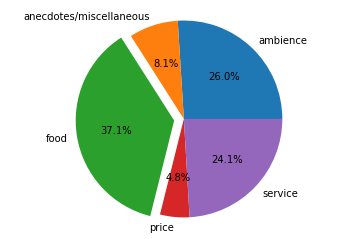

In [93]:
combined_classes = feature_classification(All_review_to_classify)

count_classes = np.sum(combined_classes , axis=0)


fig1, ax1 = plt.subplots()
ax1.pie(count_classes, explode= (0, 0, 0.1, 0 , 0) , labels = mlb.classes_ ,autopct='%1.1f%%')
ax1.axis('equal')


## Sentiment Analysis using VADER

In [76]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    

    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    if sentiment_dict['compound'] >= 0.5 : 
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.5 : 
        return "Negative"
  
    else : 
        return "Neutral"

In [79]:
all_review_df = pd.read_csv("Review_data_entire.csv")
all_review_df = all_review_df['review']


In [80]:
sentiment_df = all_review_df.apply(sentiment_scores)
analyze_df = pd.DataFrame(pd.concat([all_review_df, sentiment_df], axis = 1 ))
analyze_df.columns = ["review" , "sentiment"]
analyze_df.head()

,review,sentiment
0,"Kept passing by this new cafe, and finally ste...",Positive
1,Edited to add: This place has CBD coffee drink...,Positive
2,A place that seems to actually live up to its ...,Positive
3,Love this place. They have oat milk! Brown su...,Positive
4,Promising new coffee shop that just opened in ...,Positive


Text(0.5, 1.0, 'Sentiment of all reviews')

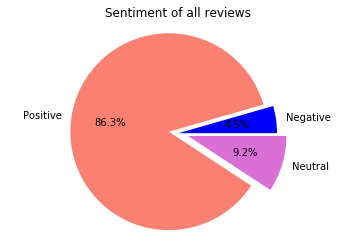

In [81]:
num_neg = analyze_df[analyze_df.sentiment == "Negative"].count().values[1]
num_pos = analyze_df[analyze_df.sentiment == "Positive"].count().values[1]
num_neu = analyze_df[analyze_df.sentiment == "Neutral"].count().values[1]

fig1, ax1 = plt.subplots()
color = ["b" , "salmon", "orchid"]
ax1.pie([num_neg , num_pos , num_neu], explode= (0, 0.1, 0.1) , \
        colors=color , labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Sentiment of all reviews")


## Negative Review Analytics (For all review in dataset)

In [84]:
negative_review = analyze_df[analyze_df.sentiment == "Negative"]

Text(0.5, 1.0, 'Number of each feature in Negative review')

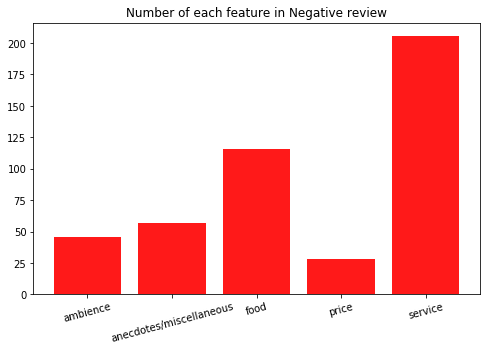

In [94]:
combined_classes = feature_classification(negative_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "r")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Negative review")



## Positive Review Analytics (for all reviews in dataset)

In [95]:
positive_review = analyze_df[analyze_df.sentiment == "Positive"]

Text(0.5, 1.0, 'Number of each feature in Negative review')

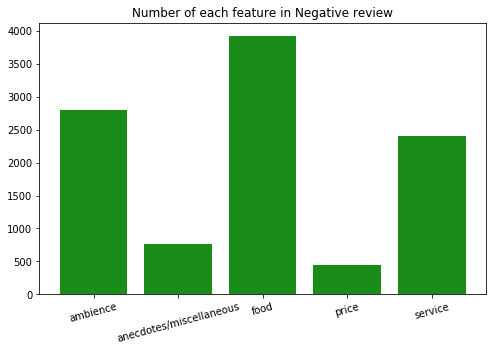

In [96]:
combined_classes = feature_classification(positive_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "g")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Negative review")


# Applications of Model

## Alice's Tea cup Chapter

In [99]:
alice_cafe = pd.read_csv("Cafe_analyze_data.csv")
alice_cafe = alice_cafe.review


In [100]:
sentiment_alice_review = alice_cafe.apply(sentiment_scores)

Text(0.5, 1.0, "Alice's Tea cafe Sentiment")

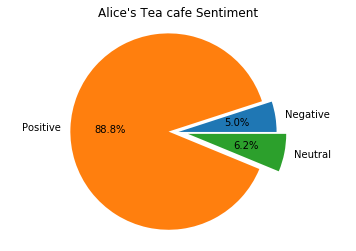

In [101]:
analyze_alice = pd.DataFrame(pd.concat([alice_cafe, sentiment_alice_review], axis = 1 ))
analyze_alice.columns = ["review" , "sentiment"]

alice_num_neg = analyze_alice[analyze_alice.sentiment == "Negative"].count().values[1]
alice_num_pos = analyze_alice[analyze_alice.sentiment == "Positive"].count().values[1]
alice_num_neu = analyze_alice[analyze_alice.sentiment == "Neutral"].count().values[1]

fig1, ax1 = plt.subplots()
ax1.pie([alice_num_neg , alice_num_pos , alice_num_neu], explode= (0, 0.1, 0.1) , labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Alice's Tea cafe Sentiment")

## Alice's Tea cup Chapter Possitive Reviews

Text(0.5, 1.0, "Number of each feature in Alice's tea Cafe Positive review")

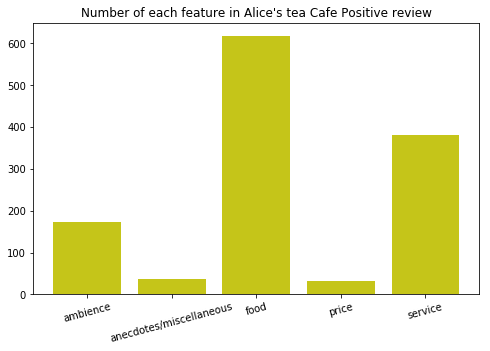

In [103]:
positive_alice_review = analyze_alice[analyze_alice.sentiment == "Positive"]

combined_classes = feature_classification(positive_alice_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "y")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Alice's tea Cafe Positive review")


## Alice's Tea cup Chapter Negative Reviews

Text(0.5, 1.0, "Number of each feature in Alice's tea Cafe Negative review")

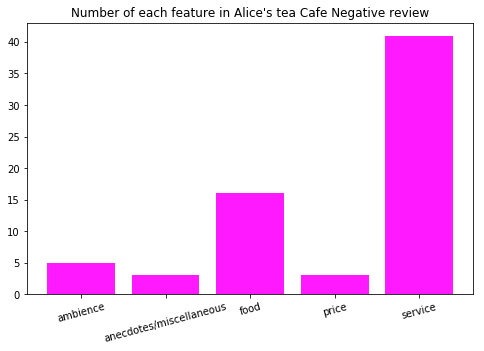

In [104]:
Negative_alice_review = analyze_alice[analyze_alice.sentiment == "Negative"]

combined_classes = feature_classification(Negative_alice_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "fuchsia")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Alice's tea Cafe Negative review")


# Saltwater Coffee

In [105]:
Saltwater_df = pd.read_csv("Review_data_entire.csv")
Saltwater_df = Saltwater_df[Saltwater_df['cafe_name'] == "Saltwater Coffee"].review

In [106]:
sentiment_saltwater_review = Saltwater_df.apply(sentiment_scores)

In [107]:
analyze_saltwater = pd.DataFrame(pd.concat([Saltwater_df, sentiment_saltwater_review], axis = 1 ))
analyze_saltwater.columns = ["review" , "sentiment"]

In [108]:
salt_num_neg = analyze_saltwater[analyze_saltwater.sentiment == "Negative"].count().values[1]
salt_num_pos = analyze_saltwater[analyze_saltwater.sentiment == "Positive"].count().values[1]
salt_num_neu = analyze_saltwater[analyze_saltwater.sentiment == "Neutral"].count().values[1]

Text(0.5, 1.0, 'Saltwater cafe Sentiment')

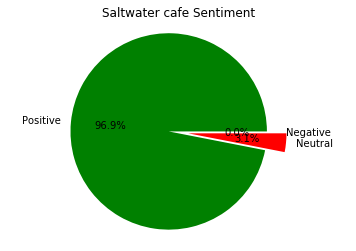

In [109]:
fig1, ax1 = plt.subplots()
color_salt = ["magenta" , "g", "r"]
ax1.pie([salt_num_neg , salt_num_pos , salt_num_neu], explode= (0, 0.1, 0.1) , \
        colors = color_salt,labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Saltwater cafe Sentiment")

## Salt Coffee Positive Review Analytics 

In [110]:
positive_salt_review = analyze_saltwater[analyze_saltwater.sentiment == "Positive"]

Text(0.5, 1.0, 'Number of each feature in Saltwater Cafe Positive review')

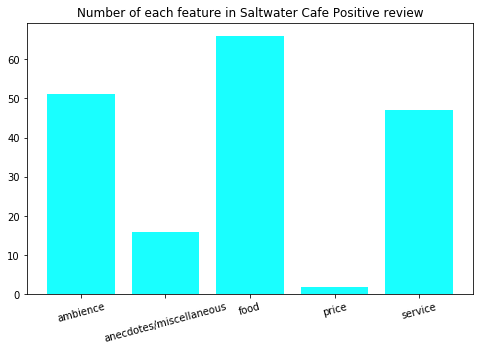

In [111]:
combined_classes = feature_classification(positive_salt_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "cyan")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Saltwater Cafe Positive review")